# load GDP netcdf file and store them as parquet

[Link](https://www.aoml.noaa.gov/phod/gdp/hourly_data.php) to GDP hourly data


In [1]:
import os
from glob import glob

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import xarray as xr

import dask.dataframe as dd
from dask.delayed import delayed

In [2]:
from dask.distributed import Client, LocalCluster

if False:
    cluster = LocalCluster()
else:
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    w = cluster.scale(jobs=5)
#
client = Client(cluster)
client

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/htcondor.py:6: FutureWarning: pars

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.31:8787/status,
Dashboard: http://10.148.0.31:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.31:54518,Workers: 0
Dashboard: http://10.148.0.31:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


----

## load all file paths

In [9]:
root_dir = "/home/datawork-lops-osi/equinox/gdp/1.04c/"
nc_dir = root_dir+"nc"
parquet_argos = os.path.join(root_dir, "argos_id.parquet")
parquet_gps = os.path.join(root_dir, "gps_id.parquet")

argos_dirs = [d for d in glob(os.path.join(nc_dir,"argos*"))]
gps_dirs = [d for d in glob(os.path.join(nc_dir,"gps*"))]

argos_files = []
for d in argos_dirs:
    argos_files += glob(os.path.join(d, "*.nc"))

gps_files = []
for d in gps_dirs:
    gps_files += glob(os.path.join(d, "*.nc"))

In [4]:
import warnings

# requires cftime: conda install -c conda-forge cftime

def ncload(f):    
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        ds = xr.open_dataset(f, decode_times=False)
        #
        for d in ["deploy_date", "end_date", "drogue_lost_date"]:
            ds[d] = ds[d].where(ds[d]>0)
        #try:
        ds = xr.decode_cf(ds)
        #except:
        #    assert False, "crash with file: {}".format(f)
        #
        ds = ds.rename(longitude="lon", latitude="lat", ID="id")
        df =  ds.squeeze().to_dataframe()
        # converts gap to seconds to ease parquet storage
        df["gap"] = df["gap"].apply(lambda x: x.total_seconds())
        return df

#df = ncload(gps_files[0])
#ncload("/home/datawork-lops-osi/equinox/gdp/1.04c/nc/gps/drifter_64700700.nc")

#### argos

In [5]:
df_argos = dd.from_delayed([delayed(ncload)(f) for f in argos_files])

df_argos = (df_argos
            .repartition(partition_size="100MB")
            .set_index("id")
            .repartition(partition_size="100MB")
            .persist()
           )

In [6]:
df_argos.to_parquet(parquet_argos, engine="pyarrow") # alternative: fastparquet

[None]

### gps

In [7]:
df_gps = dd.from_delayed([delayed(ncload)(f) for f in gps_files])
df_gps = (df_gps
            .repartition(partition_size="100MB")
            .set_index("id")
            .repartition(partition_size="100MB")
            .persist()
           )

In [8]:
df_gps.to_parquet(parquet_gps, engine='pyarrow') # alternative: fastparquet

[None]

---

## reload and compute basic diagnostics

In [10]:
df_argos = dd.read_parquet(parquet_argos)
df_gps = dd.read_parquet(parquet_gps)

In [13]:
lat_bins = np.arange(-70, 70, 1.)
#lat_idx = pd.IntervalIndex.from_breaks(lat_bins)

In [16]:
for df in [df_argos, df_gps]:
    df["lat_cut"] = df["lat"].map_partitions(pd.cut, bins=lat_bins)

In [22]:
def count(df):
    count = df.groupby("lat_cut").count().compute()
    count = count.set_index(count.index.map(lambda i: i.mid))
    return count

count_argos = count(df_argos)
count_gps = count(df_gps)

<AxesSubplot:xlabel='lat_cut'>

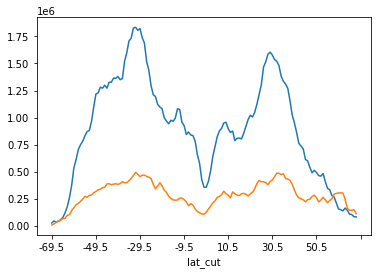

In [25]:
count_argos["time"].plot()
count_gps["time"].plot()

In [27]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


---

## dev: play with some files to figure out data architecture

In [52]:
gps_files[0]

'/home/datawork-lops-osi/equinox/gdp/1.04c/nc/gps/drifter_66813200.nc'

In [ ]:
df = ncload(gps_files[0])

In [59]:
#ds_decoded = xr.open_dataset(gps_files[0])
ds = xr.open_dataset(gps_files[0], decode_times=False)
ds

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/coding/variables.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


<xarray.Dataset>
Dimensions:           (traj: 1, obs: 4534)
Dimensions without coordinates: traj, obs
Data variables: (12/24)
    ID                (traj) |S10 ...
    rowsize           (traj) int32 ...
    WMO               (traj) float64 ...
    expno             (traj) float64 ...
    deploy_date       (traj) float32 ...
    deploy_lat        (traj) float64 ...
    ...                ...
    vn                (traj, obs) float32 ...
    err_lat           (traj, obs) float32 ...
    err_lon           (traj, obs) float32 ...
    err_ve            (traj, obs) float32 ...
    err_vn            (traj, obs) float32 ...
    gap               (traj, obs) float32 ...
Attributes: (12/71)
    title:                      Global Drifter Program hourly drifting buoy c...
    id:                         Global Drifter Program ID 66813200
    interpolation_method:       Locally Weighted Scatterplot Smoothing
    location_type:              GPS
    wmo_platform_code:          3201753
    ncei_template_version:      NCEI_NetCDF_Trajectory_Template_v2
    ...                         ...
    DrogueBallast:              1.8 kg
    DragAreaAboveDrogue:        13.08 m^2
    DragAreaOfDrogue:           564.88 m^2
    DragAreaRatio:              43.1865
    DrogueCenterDepth:          15 m
    DrogueDetectSensor:         tether strain

In [61]:
ds["end_date"] = ds.end_date.where(ds.end_date>0)
ds = xr.decode_cf(ds)

<xarray.Dataset>
Dimensions:           (traj: 1, obs: 4534)
Dimensions without coordinates: traj, obs
Data variables: (12/24)
    ID                (traj) |S10 ...
    rowsize           (traj) int32 ...
    WMO               (traj) float64 ...
    expno             (traj) float64 ...
    deploy_date       (traj) datetime64[ns] ...
    deploy_lat        (traj) float64 ...
    ...                ...
    vn                (traj, obs) float32 ...
    err_lat           (traj, obs) float32 ...
    err_lon           (traj, obs) float32 ...
    err_ve            (traj, obs) float32 ...
    err_vn            (traj, obs) float32 ...
    gap               (traj, obs) timedelta64[ns] ...
Attributes: (12/71)
    title:                      Global Drifter Program hourly drifting buoy c...
    id:                         Global Drifter Program ID 66813200
    interpolation_method:       Locally Weighted Scatterplot Smoothing
    location_type:              GPS
    wmo_platform_code:          3201753
    ncei_template_version:      NCEI_NetCDF_Trajectory_Template_v2
    ...                         ...
    DrogueBallast:              1.8 kg
    DragAreaAboveDrogue:        13.08 m^2
    DragAreaOfDrogue:           564.88 m^2
    DragAreaRatio:              43.1865
    DrogueCenterDepth:          15 m
    DrogueDetectSensor:         tether strain

In [51]:
for d in ["deploy_date", "end_date", "drogue_lost_date", ]:
    print(ds[d].values)

[-1.e+34]
[1.3656384e+09]
[1.3520736e+09]


In [48]:
#bad_file = "/home/datawork-lops-osi/equinox/gdp/1.04c/nc/gps/drifter_64700700.nc"
bad_file = "/home/datawork-lops-osi/equinox/gdp/1.04c/nc/gps/drifter_12294040.nc"
ds = xr.open_dataset(bad_file, decode_times=False)
ds

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/coding/variables.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


<xarray.Dataset>
Dimensions:           (traj: 1, obs: 7628)
Dimensions without coordinates: traj, obs
Data variables: (12/24)
    ID                (traj) |S10 ...
    rowsize           (traj) int32 ...
    WMO               (traj) float64 ...
    expno             (traj) float64 ...
    deploy_date       (traj) float32 ...
    deploy_lat        (traj) float64 ...
    ...                ...
    vn                (traj, obs) float32 ...
    err_lat           (traj, obs) float32 ...
    err_lon           (traj, obs) float32 ...
    err_ve            (traj, obs) float32 ...
    err_vn            (traj, obs) float32 ...
    gap               (traj, obs) float32 ...
Attributes: (12/71)
    title:                      Global Drifter Program hourly drifting buoy c...
    id:                         Global Drifter Program ID 12294040
    interpolation_method:       Locally Weighted Scatterplot Smoothing
    location_type:              GPS
    wmo_platform_code:          4400687
    ncei_template_version:      NCEI_NetCDF_Trajectory_Template_v2
    ...                         ...
    DrogueBallast:               kg
    DragAreaAboveDrogue:         m^2
    DragAreaOfDrogue:            m^2
    DragAreaRatio:              
    DrogueCenterDepth:           m
    DrogueDetectSensor:         unknown

In [ ]:
ds

In [ ]:
ds.start_date

In [44]:
ds.drogue_lost_date

<xarray.DataArray 'drogue_lost_date' (traj: 1)>
array([-1.e+34], dtype=float32)
Dimensions without coordinates: traj
Attributes:
    long_name:  Date of drogue loss (missing value=drogue still attached; 0=d...
    units:      seconds since 1970-01-01 00:00:00 UTC
    history:    From dirall.dat

In [40]:
xr.decode_cf(ds)

<xarray.Dataset>
Dimensions:           (traj: 1, obs: 3943)
Dimensions without coordinates: traj, obs
Data variables: (12/24)
    ID                (traj) |S10 ...
    rowsize           (traj) int32 ...
    WMO               (traj) float64 ...
    expno             (traj) float64 ...
    deploy_date       (traj) datetime64[ns] ...
    deploy_lat        (traj) float64 ...
    ...                ...
    vn                (traj, obs) float32 ...
    err_lat           (traj, obs) float32 ...
    err_lon           (traj, obs) float32 ...
    err_ve            (traj, obs) float32 ...
    err_vn            (traj, obs) float32 ...
    gap               (traj, obs) timedelta64[ns] ...
Attributes: (12/71)
    title:                      Global Drifter Program hourly drifting buoy c...
    id:                         Global Drifter Program ID 78769
    interpolation_method:       Weighted Maximum Likelihood Estimator
    location_type:              Argos
    wmo_platform_code:          6200933
    ncei_template_version:      NCEI_NetCDF_Trajectory_Template_v2
    ...                         ...
    DrogueBallast:              1.6 kg
    DragAreaAboveDrogue:        10.42 m^2
    DragAreaOfDrogue:           426.72 m^2
    DragAreaRatio:              40.952
    DrogueCenterDepth:          15 m
    DrogueDetectSensor:         tether strain

In [53]:
ds = xr.open_dataset(argos_files[0], decode_times=False)
print(ds.time.dtype)
xr.decode_cf(ds)

float64


/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/coding/variables.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/coding/variables.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/coding/variables.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/coding/variables.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwi

<xarray.Dataset>
Dimensions:           (traj: 1, obs: 3943)
Dimensions without coordinates: traj, obs
Data variables: (12/24)
    ID                (traj) |S10 ...
    rowsize           (traj) int32 ...
    WMO               (traj) float64 ...
    expno             (traj) float64 ...
    deploy_date       (traj) datetime64[ns] ...
    deploy_lat        (traj) float64 ...
    ...                ...
    vn                (traj, obs) float32 ...
    err_lat           (traj, obs) float32 ...
    err_lon           (traj, obs) float32 ...
    err_ve            (traj, obs) float32 ...
    err_vn            (traj, obs) float32 ...
    gap               (traj, obs) timedelta64[ns] ...
Attributes: (12/71)
    title:                      Global Drifter Program hourly drifting buoy c...
    id:                         Global Drifter Program ID 78769
    interpolation_method:       Weighted Maximum Likelihood Estimator
    location_type:              Argos
    wmo_platform_code:          6200933
    ncei_template_version:      NCEI_NetCDF_Trajectory_Template_v2
    ...                         ...
    DrogueBallast:              1.6 kg
    DragAreaAboveDrogue:        10.42 m^2
    DragAreaOfDrogue:           426.72 m^2
    DragAreaRatio:              40.952
    DrogueCenterDepth:          15 m
    DrogueDetectSensor:         tether strain

In [54]:
time = ds.time
delta = time.units.split()[0]
ref_date = time.units.split("since")[1]
ref_date = pd.Timestamp(ref_date)
dates = ref_date + pd.to_timedelta(list(time.values.squeeze()), delta)
dates

DatetimeIndex(['2008-08-14 08:00:00+00:00', '2008-08-14 09:00:00+00:00',
               '2008-08-14 10:00:00+00:00', '2008-08-14 11:00:00+00:00',
               '2008-08-14 12:00:00+00:00', '2008-08-14 13:00:00+00:00',
               '2008-08-14 14:00:00+00:00', '2008-08-14 15:00:00+00:00',
               '2008-08-14 16:00:00+00:00', '2008-08-14 17:00:00+00:00',
               ...
               '2009-01-25 05:00:00+00:00', '2009-01-25 06:00:00+00:00',
               '2009-01-25 07:00:00+00:00', '2009-01-25 08:00:00+00:00',
               '2009-01-25 09:00:00+00:00', '2009-01-25 10:00:00+00:00',
               '2009-01-25 11:00:00+00:00', '2009-01-25 12:00:00+00:00',
               '2009-01-25 13:00:00+00:00', '2009-01-25 14:00:00+00:00'],
              dtype='datetime64[ns, tzutc()]', length=3943, freq=None)

In [58]:
bad_file = "/home/datawork-lops-osi/equinox/gdp/1.04c/nc/argos_block8/drifter_133133.nc"
ds = xr.open_dataset(bad_file, decode_times=False)
print(ds.time.dtype)
ds.time
#xr.decode_cf(ds)

float64


/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/coding/variables.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


<xarray.DataArray 'time' (traj: 1, obs: 43533)>
array([[1.436843e+09, 1.436846e+09, 1.436850e+09, ..., 1.593551e+09,
        1.593554e+09, 1.593558e+09]])
Dimensions without coordinates: traj, obs
Attributes:
    long_name:      Time
    units:          seconds since 1970-01-01 00:00:00 UTC
    axis:           T
    valid_min:      -90.f
    valid_max:      90.f
    standard_name:  time

In [52]:
time = ds.time
delta = time.units.split()[0]
ref_date = time.units.split("since")[1]
ref_date = pd.Timestamp(ref_date)
dates = ref_date + pd.to_timedelta(list(time.values.squeeze()), delta)


#pd.to_timedelta()
delta
ref_date
dates

DatetimeIndex(['2015-07-14 03:00:00+00:00', '2015-07-14 04:00:00+00:00',
               '2015-07-14 05:00:00+00:00', '2015-07-14 06:00:00+00:00',
               '2015-07-14 07:00:00+00:00', '2015-07-14 08:00:00+00:00',
               '2015-07-14 09:00:00+00:00', '2015-07-14 10:00:00+00:00',
               '2015-07-14 11:00:00+00:00', '2015-07-14 12:00:00+00:00',
               ...
               '2020-06-30 14:00:00+00:00', '2020-06-30 15:00:00+00:00',
               '2020-06-30 16:00:00+00:00', '2020-06-30 17:00:00+00:00',
               '2020-06-30 18:00:00+00:00', '2020-06-30 19:00:00+00:00',
               '2020-06-30 20:00:00+00:00', '2020-06-30 21:00:00+00:00',
               '2020-06-30 22:00:00+00:00', '2020-06-30 23:00:00+00:00'],
              dtype='datetime64[ns, tzutc()]', length=43533, freq=None)

In [56]:
load(gps_files[0])

,id,rowsize,WMO,expno,deploy_date,deploy_lat,deploy_lon,end_date,end_lat,end_lon,...,lat,lon360,time,ve,vn,err_lat,err_lon,err_ve,err_vn,gap
obs,,,,,,,,,,,,,,,,,,,,,
0,b'66813200',4534,3201753.0,21312.0,1.564272e+09,10.857,-95.0,-1.000000e+34,-1.000000e+34,-1.000000e+34,...,10.85804,265.010986,2019-07-28 08:00:00+00:00,0.3208,-0.0113,0.00080,0.00082,0.0260,0.0260,3629.0
1,b'66813200',4534,3201753.0,21312.0,1.564272e+09,10.857,-95.0,-1.000000e+34,-1.000000e+34,-1.000000e+34,...,10.85765,265.021606,2019-07-28 09:00:00+00:00,0.3302,-0.0177,0.00057,0.00058,0.0185,0.0185,0.0
2,b'66813200',4534,3201753.0,21312.0,1.564272e+09,10.857,-95.0,-1.000000e+34,-1.000000e+34,-1.000000e+34,...,10.85680,265.031830,2019-07-28 10:00:00+00:00,0.2965,-0.0309,0.00036,0.00037,0.0137,0.0137,3629.0
3,b'66813200',4534,3201753.0,21312.0,1.564272e+09,10.857,-95.0,-1.000000e+34,-1.000000e+34,-1.000000e+34,...,10.85563,265.041595,2019-07-28 11:00:00+00:00,0.2810,-0.0407,0.00037,0.00038,0.0137,0.0137,3629.0
4,b'66813200',4534,3201753.0,21312.0,1.564272e+09,10.857,-95.0,-1.000000e+34,-1.000000e+34,-1.000000e+34,...,10.85374,265.050842,2019-07-28 12:00:00+00:00,0.2889,-0.0736,0.00050,0.00051,0.0184,0.0184,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4529,b'66813200',4534,3201753.0,21312.0,1.564272e+09,10.857,-95.0,-1.000000e+34,-1.000000e+34,-1.000000e+34,...,13.26740,247.959641,2020-02-10 11:00:00+00:00,-0.1730,0.0510,0.00056,0.00057,0.0128,0.0128,21600.0
4530,b'66813200',4534,3201753.0,21312.0,1.564272e+09,10.857,-95.0,-1.000000e+34,-1.000000e+34,-1.000000e+34,...,13.27127,247.951797,2020-02-10 12:00:00+00:00,-0.1565,0.0874,0.00066,0.00067,0.0157,0.0157,21600.0
4531,b'66813200',4534,3201753.0,21312.0,1.564272e+09,10.857,-95.0,-1.000000e+34,-1.000000e+34,-1.000000e+34,...,13.27513,247.943939,2020-02-10 13:00:00+00:00,-0.1400,0.1237,0.00078,0.00080,0.0188,0.0188,21600.0


In [59]:
load(bad_file)

,id,rowsize,WMO,expno,deploy_date,deploy_lat,deploy_lon,end_date,end_lat,end_lon,...,lat,lon360,time,ve,vn,err_lat,err_lon,err_ve,err_vn,gap
obs,,,,,,,,,,,,,,,,,,,,,
0,b'133133',43533,4400521.0,9325.0,1.436659e+09,37.258,-70.0,-1.000000e+34,-1.000000e+34,-1.000000e+34,...,37.261150,289.929047,2015-07-14 03:00:00+00:00,-0.2381,0.1359,0.00653,0.00405,0.0294,0.0330,14681.0
1,b'133133',43533,4400521.0,9325.0,1.436659e+09,37.258,-70.0,-1.000000e+34,-1.000000e+34,-1.000000e+34,...,37.265099,289.919647,2015-07-14 04:00:00+00:00,-0.2389,0.1375,0.00504,0.00302,0.0294,0.0322,14681.0
2,b'133133',43533,4400521.0,9325.0,1.436659e+09,37.258,-70.0,-1.000000e+34,-1.000000e+34,-1.000000e+34,...,37.268909,289.910278,2015-07-14 05:00:00+00:00,-0.2400,0.1403,0.00360,0.00210,0.0298,0.0311,14681.0
3,b'133133',43533,4400521.0,9325.0,1.436659e+09,37.258,-70.0,-1.000000e+34,-1.000000e+34,-1.000000e+34,...,37.272499,289.900940,2015-07-14 06:00:00+00:00,-0.2416,0.1473,0.00252,0.00129,0.0319,0.0302,14681.0
4,b'133133',43533,4400521.0,9325.0,1.436659e+09,37.258,-70.0,-1.000000e+34,-1.000000e+34,-1.000000e+34,...,37.277679,289.891144,2015-07-14 07:00:00+00:00,-0.2427,0.1520,0.00224,0.00280,0.0372,0.0304,9112.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43528,b'133133',43533,4400521.0,9325.0,1.436659e+09,37.258,-70.0,-1.000000e+34,-1.000000e+34,-1.000000e+34,...,31.551991,316.717316,2020-06-30 19:00:00+00:00,0.0498,-0.0594,0.00180,0.00736,0.0341,0.0186,21600.0
43529,b'133133',43533,4400521.0,9325.0,1.436659e+09,37.258,-70.0,-1.000000e+34,-1.000000e+34,-1.000000e+34,...,31.550409,316.719879,2020-06-30 20:00:00+00:00,0.0512,-0.0613,0.00173,0.00910,0.0343,0.0187,21600.0
43530,b'133133',43533,4400521.0,9325.0,1.436659e+09,37.258,-70.0,-1.000000e+34,-1.000000e+34,-1.000000e+34,...,31.547640,316.714935,2020-06-30 21:00:00+00:00,-0.2276,-0.0766,0.00079,0.00879,0.1889,0.0120,6160.0


/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when 

In [ ]:
def parse_dates(ds, v):
    time = ds[v]
    delta = time.units.split()[0]
    ref_date = time.units.split("since")[1]
    ref_date = pd.Timestamp(ref_date)
    tvalues = time.values
    if len(tvalues.shape)>1:
        tvalues = tvalues.squeeze()
    dates = ref_date + pd.to_timedelta(list(tvalues), delta)
    return dates
    